In [4]:
import sys
import pandas as pd
import altair as alt
import numpy as np
import pprint
import datetime as dt
from vega_datasets import data

In [5]:
df = pd.read_csv('billboard_200_cleaned.csv')

In [6]:
df.head()


,date,Artist,Song/Album Title,Peak Position,Weeks on Chart,year,generation,debut_years
0,2009-04-04,BoA,BoA[6],127,1,2009,1,1996 - 2004
1,2012-03-17,Big Bang,Alive[7][8],150,1,2012,2,2005 - 2011
2,2012-05-12,Girls' Generation-TTS,Twinkle[9][10],126,1,2012,2,2005 - 2011
3,2012-09-29,G-Dragon,One of a Kind[8],161,1,2012,2,2005 - 2011
4,2013-09-21,G-Dragon,Coup d'Etat Pt.1[8],182,1,2013,2,2005 - 2011


In [7]:
# Remove citations like [8] from the column
df['Song/Album Title'] = df['Song/Album Title'].str.replace(r'\[\d+\]', '', regex=True)

In [8]:
df.head()

,date,Artist,Song/Album Title,Peak Position,Weeks on Chart,year,generation,debut_years
0,2009-04-04,BoA,BoA,127,1,2009,1,1996 - 2004
1,2012-03-17,Big Bang,Alive,150,1,2012,2,2005 - 2011
2,2012-05-12,Girls' Generation-TTS,Twinkle,126,1,2012,2,2005 - 2011
3,2012-09-29,G-Dragon,One of a Kind,161,1,2012,2,2005 - 2011
4,2013-09-21,G-Dragon,Coup d'Etat Pt.1,182,1,2013,2,2005 - 2011


In [9]:
# The dataframe is the frequence of the genreation performance in the billboard 200
gen_count = df.pivot_table(index='generation', columns='year', values='Weeks on Chart', aggfunc='count', fill_value=0)

## Graph_4th_gen

### Timeline of Billboard 200 - highlight 2009, 2018 and 2023

### Annotations to Insert:



1. In 2023, 35 albums reached the Billboard 200, with five climbing to the number one spot. NewJeans' Get Up held the top position the longest, staying on the chart for 26 weeks. Other notable top albums include:

- The Name Chapter: Temptation - TXT
- 5-Star - Stray Kids
- Rock-Star - Stray Kids
- The World EP.Fin: Will - Ateez

<!-- 2. Except for Billboard, Spotify’s Billions Club, a prestige playlist with tracks that have over a billion streams, continues to welcome K-pop songs. In 2023, BTS member Jimin’s “Like Crazy and BTS member Jungkook’s “Seven” joined the club. Jungkook’s “Seven” reached the one-billion-streams threshold after just 108 days since its release, making it the fastest track in Spotify’s history to join the club. -->


❗️❗️❗️ TODO: 


2. Insert: https://youtube.com/clip/UgkxE2AcnHpwSbmlsZqO9MjsoHsgFO8V_fuj?si=QxrdC95oGYHu1Lw0








In [10]:
columns = ['Song/Album Title', 'Artist', 'Peak Position', 'Weeks on Chart', 'year', 'generation']
df = df[columns]
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [11]:

#TODO: replicate vis3


# Create a selection and condition for the vertical line, annotation dots, and text annotations
hover = alt.selection_single(on='mousemove', nearest=True, fields=['year'], empty='none')



# Create the base chart and filter to All polls
base = alt.Chart(df).transform_aggregate(
    total_songs='count()',
    groupby=['year', 'generation']
).transform_filter(
    alt.datum.total_songs > 0
).mark_line(size=2.5).encode(
    x=alt.X('year:T', title=None, axis=alt.Axis(
        format='%Y',
        labelAngle=-45,     # Rotate labels for readability
        labelOverlap='greedy'  # Automatically manage overlapping labels
    )),
    y=alt.Y(
        'total_songs:Q',
        title='The Number of Songs/Albums',
        scale=alt.Scale(nice=True)  # Automatically adjust the range of y-axis
    ),
    color='generation:N'
).properties(
    width=600,
    height=500
)

# Static line chart
line_chart = base

# Vertical line
vline = alt.Chart(df).mark_rule(size=2, color='lightgray').encode(
    x='year:T',
    opacity=alt.condition(hover, alt.value(1), alt.value(0))
).add_selection(
    hover
)

#interaction dots
interaction_dots = alt.Chart(df).transform_aggregate(
    total_songs='count()',
    groupby=['year', 'generation']
).mark_circle(size=90).encode(
    x='year:T',
    y='total_songs:Q',
    color='generation:N',
    opacity=alt.condition(hover, alt.value(1), alt.value(0))
).transform_filter(
    hover
)

#interaction text labels
text_labels = alt.Chart(df).transform_aggregate(
    total_songs='count()',
    groupby=['year', 'generation']
).mark_text(fontSize=14, align='left', dx=7).encode(
    x='year:T',
    y='total_songs:Q',
    text=alt.Text('total_songs:Q', format='.0f'),
    color='generation:N',
    opacity=alt.condition(hover, alt.value(1), alt.value(0))
).transform_filter(
    hover
)


# Create a bar chart to show the average weeks on chart by generation
bars = alt.Chart(df).mark_bar().encode(
        x=alt.X(
        'mean(Weeks on Chart):Q', 
        title='Average Weeks on Chart',
            axis=alt.Axis(
            format='.0f',  # Show integers only
            tickCount=5    # Limit the number of ticks
        ),
        scale=alt.Scale(domain=[0, 14])  # Set x-axis range to match your data
    ),
    y=alt.Y('generation:N', sort='x', title='Generation'),
    color=alt.Color(
        'generation:N',  # Align bar colors with generations
        scale=alt.Scale(scheme='category10'),  # Use a consistent color scheme
        legend=None  # Hide the legend if it's not needed
    ),
    tooltip=['generation:N', 'mean(Weeks on Chart):Q']
).transform_window(
    rank='rank(mean(Weeks on Chart))',
    sort=[alt.SortField('mean(Weeks on Chart)', order='descending')]
).transform_filter(
    hover
).properties(
    title='Average Weeks on Chart by Generation'
)

# Combine charts (if needed)

#Put them all together
chart = alt.layer(line_chart, vline, interaction_dots, text_labels).properties(
    title={
        "text": "The Number of K-pop Albums that Hit Billboard 200 by Year",
        "subtitle": "Grouped by Generation",
        "fontSize": 16,
        "font": "Arial",
        "anchor": "middle",
    }
)

chart

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_3477/3841426153.py:5: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  hover = alt.selection_single(on='mousemove', nearest=True, fields=['year'], empty='none')
/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_3477/3841426153.py:39: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.LayerChart(...)

In [ ]:
# Combine the choropleth map and bar chart
combined_chart = alt.vconcat(chart, bars)

combined_chart


alt.VConcatChart(...)

In [ ]:

# # Create a custom color palette
# colors = ['gray' if year < 2017 or year > 2023 else sns.color_palette('Set2')[i % 8] for i, year in enumerate(year_total.index)]


# plt.figure(figsize=(12, 6))
# sns.barplot(x=year_total.index, y=year_total['Weeks on Chart'], palette=colors)

# plt.title('The Number of K-pop Albums that Hit Billboard 200 by Year')
# plt.xlabel('Year')
# plt.ylabel('The Number of K-pop Albums')
# plt.xticks(rotation=45)

# # Remove ticks
# plt.tick_params(left=False, bottom=False)
# plt.grid(False)

# # Remove the border
# sns.despine()

# plt.show()

In [14]:
artist_total = df.pivot_table(index='Artist',  values='Weeks on Chart', aggfunc='count', fill_value=0)



In [15]:
artist_total = artist_total.reset_index()
artist_total = artist_total.rename(columns={'Weeks on Chart': 'num'})

In [16]:
df = artist_total
# Create generation based on artist name
df['generation'] = 0
df['generation'] = np.where(df['Artist'] == 'BoA', 1, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Big Bang', '2NE1', "Girls' Generation-TTS", "Girls' Generation", 'Taeyang', 'G-Dragon', "Jackson Wang", 'Jonghyun']), 2, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Exo', 'BTS', "Blackpink", "Exo-K", 'The Rose', 'Seventeen', 'Twice', 'Red Velvet', 'Jimin', 'Jungkook', 'NCT 127', 'NCT Dream', 'NCT', 'J-Hope', 'Loona', 'Nayeon', 'Agust D', 'Jihyo', 'DPR Ian', 'SuperM', 'Monsta X', 'RM', 'V']), 3, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Stray Kids', '(G)I-dle', 'TXT', 'Itzy', 'Ateez', 'Aespa', 'NewJeans', 'Enhypen', 'Le Sserafim', 'Nmixx', 'P1Harmony', 'Kep1er' ]), 4, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Babymonster', 'Illit', 'BoyNextDoor', 'Xikers']), 5, df['generation'])



## Graph_3&4_gen

### Annotations to insert

- Among the Top 20 K-pop groups and singers with the most Billboard 200 hits, nine are from the 3rd generation, with Twice and Blackpink being the only girl groups. Another nine belong to the 4th generation, evenly divided between three boy bands and three girl groups. The 5th-generation group BoyNextDoor and the 2nd-generation artist G-Dragon each have one entry on the list.

 


In [21]:
# Create the bar chart
chart = alt.Chart(df).transform_window(
    rank='rank(num)',
    sort=[alt.SortField('num', order='descending')]
).transform_filter(
    alt.datum.rank <= 20
).mark_bar().encode(
        x=alt.X('Artist:N', sort='-y', title=None, axis=alt.Axis(
        labelAngle=-45,     # Rotate labels for readability
    )),
    y=alt.Y('num:Q', title='Frequency of Hitting Billboard 200'),
    color=alt.Color('generation:N', legend=None),  # Use different colors for each artist
    tooltip=[
        alt.Tooltip('num:Q', title='Frequency'),  # Format to 2 decimals
        alt.Tooltip('generation:N', title='Generation')
    ]
).properties(
    title='Top 20 K-pop Groups with the Most Billboard 200 Hits (2009-2023)',
    width=600,
    height=400
)

In [22]:
chart

alt.Chart(...)

In [ ]:
# Define the custom color palette based on the artist names
def get_color(artist):
    if artist in ['BTS', 'NCT 127', 'Seventeen']:
        return 'lightblue'
    elif artist == 'Twice':
        return 'pink'
    elif artist in ['TXT', 'Enhypen', 'Stray Kids']:
        return 'lightgreen'
    elif artist in ['Ateez', 'Aespa', 'Itzy']:
        return 'purple'
    else:
        return 'gray'



/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_98782/2153534091.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_artists.index, y=top_10_artists['Weeks on Chart'], palette=colors)


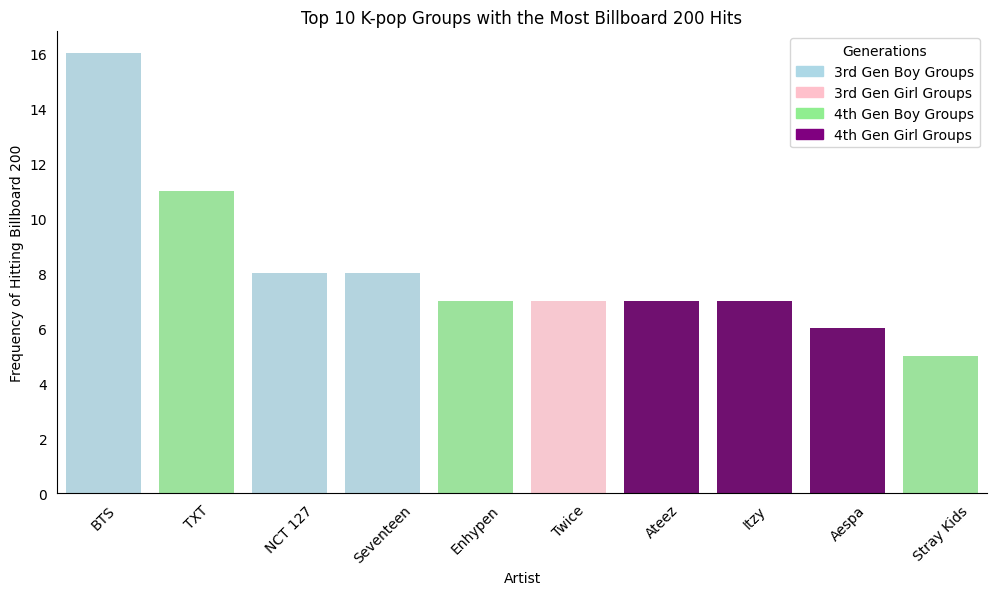

In [ ]:
from matplotlib.patches import Patch
# Select the top 10 artists
top_10_artists = artist_total_sorted.head(10)

# Apply the custom color palette to the DataFrame
colors = [get_color(artist) for artist in top_10_artists.index]

# Plot the bar plot with the custom color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_artists.index, y=top_10_artists['Weeks on Chart'], palette=colors)

plt.title('Top 10 K-pop Groups with the Most Billboard 200 Hits')
plt.xlabel('Artist')
plt.ylabel('Frequency of Hitting Billboard 200')
plt.xticks(rotation=45)

# Create custom legend handles
legend_handles = [
    Patch(color='lightblue', label='3rd Gen Boy Groups'),
    Patch(color='pink', label='3rd Gen Girl Groups'),
    Patch(color='lightgreen', label='4th Gen Boy Groups'),
    Patch(color='purple', label='4th Gen Girl Groups')
]

# Add the legend to the plot
plt.legend(handles=legend_handles, title='Generations', loc='upper right')

# Remove ticks
plt.tick_params(left=False, bottom=False)

# Remove the border
sns.despine()

plt.grid(False)
plt.show()



In [ ]:
# Create generation based on artist name
df['generation'] = np.where(df['Artist'] == 'BoA', 1, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Big Bang', '2NE1', "Girls' Generation-TTS", "Girls' Generation", 'Taeyang', 'G-Dragon', "Jackson Wang", 'Jonghyun']), 2, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Exo', 'BTS', "Blackpink", "Exo-K", 'The Rose', 'Seventeen', 'Twice', 'Red Velvet', 'Jimin', 'Jungkook', 'NCT 127', 'NCT Dream', 'NCT', 'J-Hope', 'Loona', 'Nayeon', 'Agust D', 'Jihyo', 'DPR Ian', 'SuperM', 'Monsta X', 'RM', 'V']), 3, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Stray Kids', '(G)I-dle', 'TXT', 'Itzy', 'Ateez', 'Aespa', 'NewJeans', 'Enhypen', 'Le Sserafim', 'Nmixx', 'P1Harmony', 'Kep1er' ]), 4, df['generation'])
df['generation'] = np.where(df['Artist'].isin(['Babymonster', 'Illit', 'BoyNextDoor', 'Xikers']), 5, df['generation'])
